In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('taxi-analysis').getOrCreate()

In [7]:
trip_files = "C://Users//yms06//PYTHONTEST//spark//data-engineering//01-spark//data//trips//*"
zone_file = "C://Users//yms06//PYTHONTEST//spark//data-engineering//01-spark//data//taxi+_zone_lookup.csv"

In [13]:
trips_df = spark.read.parquet(f"{trip_files}")
zone_df = spark.read.csv(f"{zone_file}", inferSchema=True, header=True)

In [14]:
trips_df.printSchema()
zone_df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zo

In [15]:
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [40]:
query = """
SELECT 
    t.VendorID as vendor_id,
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    pz.Zone as pickup_zone,
    dz.Zone as dropoff_zone
FROM 
    trips t
    LEFT JOIN
        zone pz
    ON
        t.PULocationID = pz.LocationID
    LEFT JOIN
        zone dz
    ON
        t.DOLocationID = dz.LocationID
"""
comb_df = spark.sql(query)
comb_df.createOrReplaceTempView('comb')

In [31]:
comb_df.printSchema()

root
 |-- vendor_id: long (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [35]:
spark.sql(
    """
    SELECT 
        pickup_date,
        pickup_time
    FROM comb
    WHERE pickup_date > '2020-12-31'
    ORDER BY pickup_date 
    """
).show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
| 2021-01-01|          9|
+-----------+-----------+
only showing top 20 rows



In [37]:
comb_df.select("total_amount").describe().show()

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          15000936|
|   mean|18.755400510852745|
| stddev|145.74310219086007|
|    min|            -647.8|
|    max|          398469.2|
+-------+------------------+



In [38]:
comb_df.select("trip_distance").describe().show()

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000936|
|   mean|6.628556730059916|
| stddev|671.7240645480979|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



In [41]:
comb_df.select("passenger_count").describe().show()

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166908|
|   mean|1.4253582362502812|
| stddev| 1.044333600318908|
|    min|               0.0|
|    max|               9.0|
+-------+------------------+



In [45]:
query = """
SELECT 
    DATE_TRUNC('MM', c.pickup_date) AS month,
    COUNT(*) AS trips
FROM
    comb c
GROUP BY
    month
ORDER BY 
    month desc
"""
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|  49452|
|2021-07-01 00:00:00|2825121|
|2021-06-01 00:00:00|2813017|
|2021-05-01 00:00:00|2522860|
|2021-04-01 00:00:00|2156143|
|2021-03-01 00:00:00|1910234|
|2021-02-01 00:00:00|1368619|
|2021-01-01 00:00:00|1355332|
|2020-12-01 00:00:00|      1|
|2009-01-01 00:00:00|    137|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      2|
+-------------------+-------+



In [46]:
# Data Clearning
query = """
SELECT
    *
FROM 
    comb c
WHERE 
    c.total_amount < 5000
    AND c.total_amount > 0
    AND c.trip_distance < 100
    AND c.passenger_count < 4
    AND c.pickup_date >= '2021-01-01'
    AND c.pickup_date < '2021-08-01'
"""
cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView('cleaned')

In [49]:
cleaned_df.describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|summary|         vendor_id|       pickup_time|     dropoff_time|   passenger_count|     trip_distance|       fare_amount|        tip_amount|       tolls_amount|      total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|  count|          13253642|          13253642|         13253642|          13253642|          13253642|          13253642|          13253642|           13253642|          13253642|           13253642|            13253642|            13253642|
|   mean|1.6707765307075595|

In [51]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [56]:
query = """
SELECT 
    c.pickup_date,
    COUNT(*) AS trips
FROM 
    cleaned c
GROUP BY 
    c.pickup_date
ORDER BY
    pickup_date asc
"""

pd_df = spark.sql(query).toPandas()

<Axes: xlabel='pickup_date', ylabel='trips'>

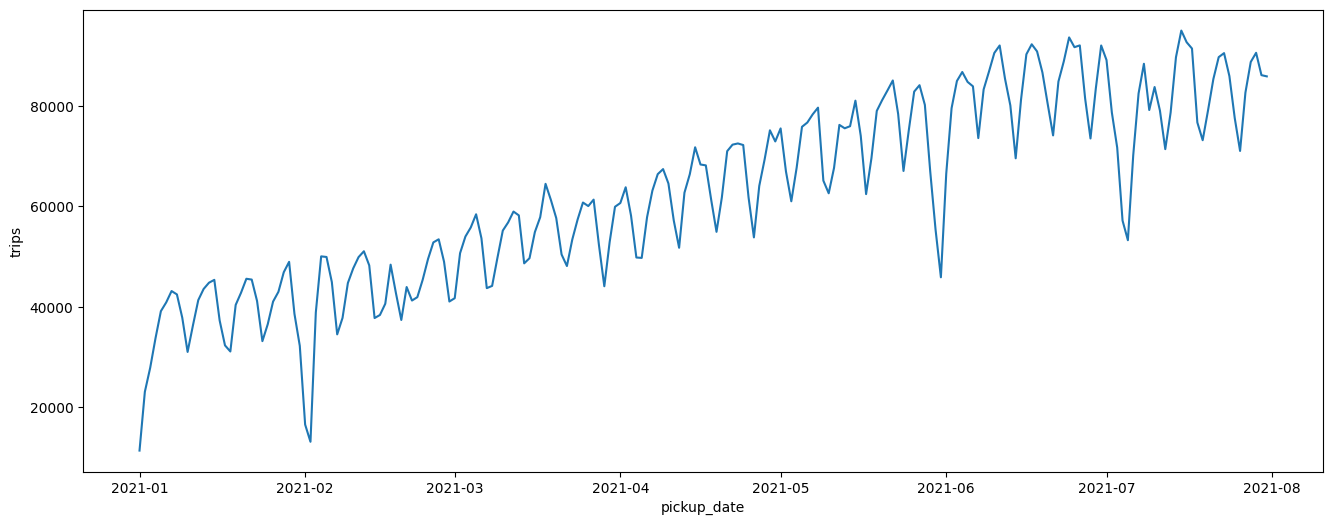

In [60]:
fig, ax = plt.subplots(figsize = (16, 6))
sns.lineplot(x = 'pickup_date', y = 'trips', data=pd_df)

In [64]:
query = """
SELECT 
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM 
    cleaned c
GROUP BY 
    c.pickup_date,
    day_of_week
ORDER BY
    pickup_date asc
"""

pd_df2 = spark.sql(query).toPandas()

In [71]:
data = pd_df2.groupby("day_of_week").trips.median().to_frame().reset_index()
data["sort_dow"] = data['day_of_week'].replace({
    "Sunday": 0,
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
})

In [73]:
data.sort_values(by='sort_dow', inplace=True)

<Axes: xlabel='day_of_week', ylabel='trips'>

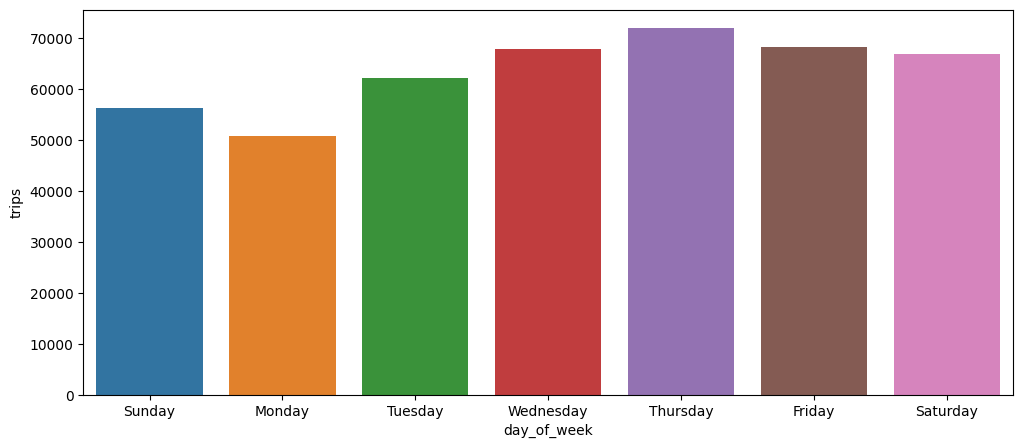

In [75]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(
    x = 'day_of_week',
    y = "trips",
    data=data
)

In [76]:
def get_weekday(date):
    import calendar
    return calendar.day_name[date.weekday()]

spark.udf.register('get_weekday', get_weekday)

<function __main__.get_weekday(date)>

In [80]:
query = """
SELECT 
    c.pickup_date,
    get_weekday(c.pickup_date) AS day_of_week,
    COUNT(*) AS trips
FROM 
    cleaned c
GROUP BY 
    c.pickup_date,
    day_of_week
ORDER BY
    pickup_date asc
"""

In [82]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip"
}

def pares_payment_type(payment_type):
    return payment_type_to_string[payment_type]

spark.udf.register("pares_payment_type", pares_payment_type)

<function __main__.pares_payment_type(payment_type)>

In [85]:
query = """
SELECT 
    pares_payment_type(payment_type),
    COUNT(*) AS trips,
    MEAN(fare_amount) AS mean_fare_amount,
    STD(fare_amount) AS stdev_fare_amount
FROM
    cleaned
GROUP BY
    payment_type
"""

spark.sql(query).show()

+--------------------------------+--------+------------------+------------------+
|pares_payment_type(payment_type)|   trips|  mean_fare_amount| stdev_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10084721| 12.21239665430302| 10.79305950738761|
|                       No Charge|   58394|11.927290988800213|15.041269068746274|
|                            Cash| 3087063|11.978198702132046| 11.47320685970618|
|                         Dispute|   23463| 12.63930315816392|14.154693719632084|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+

